In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import joblib
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train=pd.read_csv(r'C:\Users\ayish\GuviProjects\Horse race Prediction\df_train.csv')
df_test=pd.read_csv(r'C:\Users\ayish\GuviProjects\Horse race Prediction\df_test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21139 entries, 0 to 21138
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   finishing_position     21139 non-null  int64  
 1   horse_number           21139 non-null  float64
 2   horse_name             21139 non-null  object 
 3   horse_id               21139 non-null  object 
 4   jockey                 21139 non-null  object 
 5   trainer                21139 non-null  object 
 6   actual_weight          21139 non-null  int64  
 7   declared_horse_weight  21139 non-null  int64  
 8   draw                   21139 non-null  int64  
 9   length_behind_winner   21139 non-null  object 
 10  running_position_1     21139 non-null  float64
 11  running_position_2     21139 non-null  float64
 12  running_position_3     21139 non-null  float64
 13  running_position_4     11905 non-null  float64
 14  finish_time            21139 non-null  object 
 15  wi

In [3]:
df = df_train[['horse_name', 'horse_number', 'jockey',
                'actual_weight', 'declared_horse_weight',
                    'draw', 'win_odds', 'jockey_ave_rank',
                     'recent_ave_rank', 'race_distance', 'HorseWin', 'HorseRankTop3']]

dftest = df_test[['horse_name', 'horse_number', 'jockey',
                 'actual_weight', 'declared_horse_weight',
                'draw', 'win_odds', 'jockey_ave_rank',    
                 'recent_ave_rank', 'race_distance', 'HorseWin', 'HorseRankTop3']]

In [4]:
df.isna().sum()

horse_name               0
horse_number             0
jockey                   0
actual_weight            0
declared_horse_weight    0
draw                     0
win_odds                 0
jockey_ave_rank          0
recent_ave_rank          0
race_distance            0
HorseWin                 0
HorseRankTop3            0
dtype: int64

In [4]:
X_train = df.drop(['horse_name', 'horse_number', 'jockey', 'HorseWin', 'HorseRankTop3'], axis=1)
y_train = df['HorseWin']

X_test = dftest.drop(['horse_name', 'horse_number', 'jockey', 'HorseWin', 'HorseRankTop3'], axis=1)
y_test = dftest['HorseWin']

In [5]:
sm = SMOTE(random_state = 42)
rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                               random_state = 42)

# Steps for the pipeline
steps = [('smote', sm), ('rfc', rfc)]

# Create the pipeline
smote_rfc = Pipeline(steps = steps)

In [6]:
smote_rfc.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rfc',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                                        random_state=42))])

In [7]:
kfold = KFold(n_splits=5)
cv_score = cross_val_score(smote_rfc, X_train, y_train, cv=kfold, scoring='f1_weighted').mean()
cv_score = round(cv_score, 3)

# Create a dataframe to store the predictions
df_pred = pd.DataFrame()
df_pred['RaceID'] = df_test['race_id']
df_pred['HorseID'] = df_test['horse_id']

# Make predictions
y_test_pred = smote_rfc.predict(X_test)

# Store the predictions in the dataframe
df_pred['HorseWin'] = y_test_pred

# Calculate the f1 score
f1 = f1_score(y_test, y_test_pred, average='weighted')
f1 = round(f1, 3)

# Calculate PR AUC
pr_auc = average_precision_score(y_test, y_test_pred, average='weighted')
pr_auc = round(pr_auc, 3)

# Calculate TPR
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
tpr = tp / (tp + fn)
tpr = round(tpr, 3)

 # Print the results
print('Cross Validation Score: ', cv_score)
print('F1 Score: ', f1)
print('PR AUC (Avg Precision): ', pr_auc)
print('TPR: ', tpr)


Cross Validation Score:  0.855
F1 Score:  0.789
PR AUC (Avg Precision):  0.129
TPR:  0.58


In [8]:
# Define a function to backtest the betting strategy
def simple_class_strategy(model_pred, graph=True):

    df_test_results = df_test[['finishing_position', 'win_odds', 
                                'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_backtest = pd.merge(model_pred, df_test_results, on=('RaceID', 'HorseID'), how='left')

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_backtest['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_backtest[df_backtest['RaceID']==race_id]

        # find out the bets we made
        bets = temp_df[temp_df['HorseWin']==1]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.title('Cumulative Money')
        plt.xlabel
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

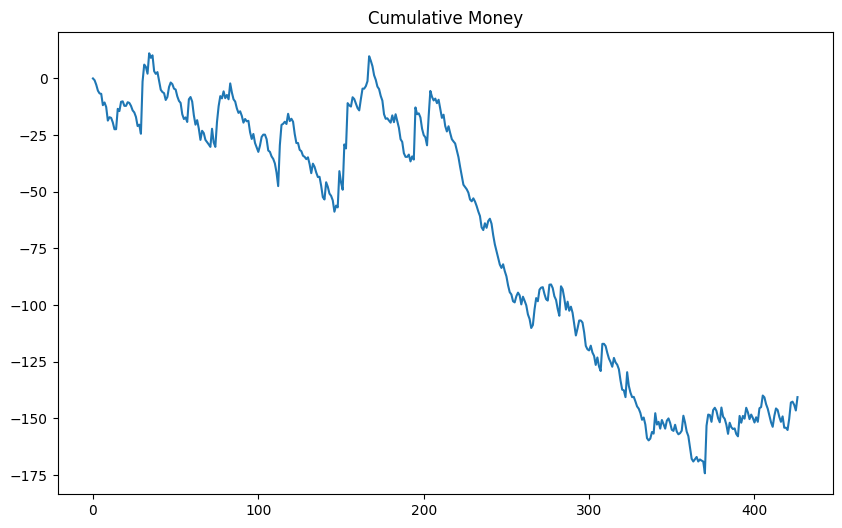

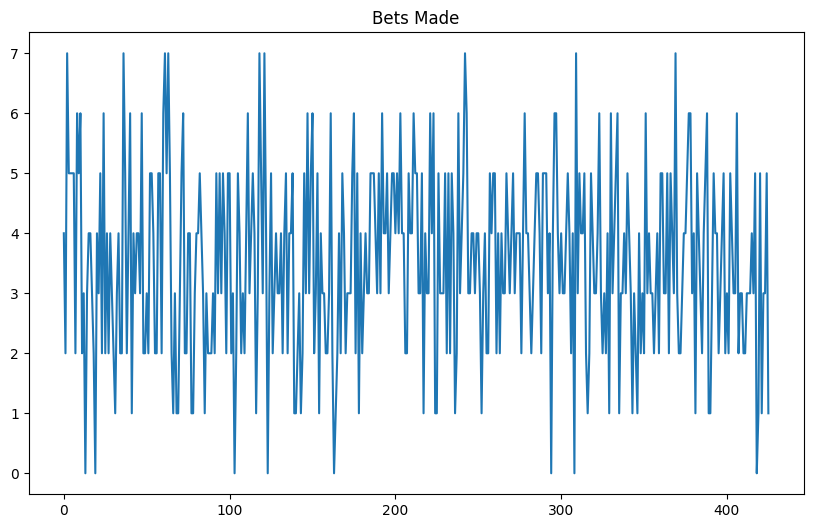

Final Money:  -140.6
Total Bets Made:  1493 



In [9]:
app_testing = simple_class_strategy(df_pred, graph=True)

In [10]:
pd.DataFrame(df_pred).to_csv('deploy_pred.csv')

In [11]:
# pickle the model

# create the data to pickle
data = {"model": smote_rfc, 'train_data': df_train, 'test_data': df_test}

# open a file, where you ant to store the data
file = open('saved_steps.pkl', 'wb')

# dump information to that file
pickle.dump(data, file)

In [12]:
# We want to be able to show that our deployment app is working
# Find index of df_pred where HorseWin = 1
index = df_pred[df_pred['HorseWin']==1].index

# Pass the index through to the test data
horsesPred1 = df_test.iloc[index]

# Keep only the columns we need
horsesPredCol = ['horse_name', 'horse_number', 'jockey', 'draw', 'win_odds', 'race_distance',
                'actual_weight', 'declared_horse_weight', 'recent_ave_rank',
                'finishing_position', 'HorseWin', 'jockey_ave_rank', 'trainer_ave_rank']

In [13]:
horsesPred1[horsesPredCol][:20]

,horse_name,horse_number,jockey,draw,win_odds,race_distance,actual_weight,declared_horse_weight,recent_ave_rank,finishing_position,HorseWin,jockey_ave_rank,trainer_ave_rank
0,SUPER FLUKE,11.0,J Moreira,6,3.2,1650,118,1118,4.941176,1,1,4.070707,8.052941
5,THE SYLPH,6.0,D Whyte,3,6.0,1650,120,1025,5.518519,6,0,6.309091,6.197425
6,HAPPY PLACE,2.0,N Rawiller,2,5.5,1650,131,1136,5.526316,7,0,6.180556,6.824268
9,BEAUTY LOVE,8.0,S de Sousa,5,6.1,1650,119,1076,6.416667,10,0,5.995192,6.255663
14,BLISS CARTEL,9.0,J Moreira,2,2.0,1650,118,1087,7.176471,4,0,4.070707,6.197425
20,REAL SUPREME,4.0,O Doleuze,10,16.0,1650,131,1160,7.269231,10,0,7.017045,7.865672
22,BLOCKER DEE,3.0,K Teetan,11,4.4,1200,125,1260,2.444444,1,1,6.523077,6.990000
23,FLYING TOURBILLON,10.0,S de Sousa,1,4.4,1200,120,1126,6.944444,2,0,5.995192,6.468354
24,DRAGON GENERAL,7.0,C Schofield,5,26.0,1200,123,1110,3.727273,3,0,6.877660,7.207358
25,BACK IN BLACK,6.0,Z Purton,4,5.0,1200,123,1076,3.692308,4,0,5.381988,6.858209
